In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [104]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

In [107]:
img_array = cv2.imread("/kaggle/input/drowsiness-detection/closed_eye/s0001_00002_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)

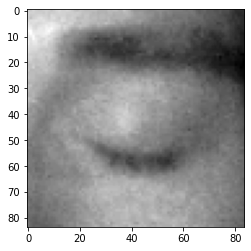

In [108]:
plt.imshow(img_array, cmap="gray")

In [109]:
img_array.shape

(84, 84)

In [110]:
# %cd ..

In [111]:
!ls

input  lib  working


In [112]:
data_path = "/kaggle/input/drowsiness-detection/"
classes = ["closed_eye", "open_eye"]
img_size = 224

In [117]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(data_path, target_size=(img_size, img_size), batch_size=32, class_mode='binary', subset='training')
val_generator = datagen.flow_from_directory(data_path, target_size=(img_size, img_size), batch_size=32, class_mode='binary', subset='validation')

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [253]:
base_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), weights='imagenet')

In [254]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [256]:
base_model.trainable = False

**Transfer learning**

In [257]:
base_input = base_model.layers[0].input

In [258]:
base_output =  base_model.layers[-4].output

In [259]:
base_output

<KerasTensor: shape=(None, 1, 1, 1024) dtype=float32 (created by layer 'dropout')>

In [260]:
flat_layer = tf.keras.layers.Flatten()(base_output)
final_output = tf.keras.layers.Dense(1, activation="sigmoid")(flat_layer)

In [261]:
model = tf.keras.Model(inputs = base_input, outputs = final_output)

In [262]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [263]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [264]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=val_generator,
    validation_steps = val_generator.samples // 32,
    epochs=2
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
1200/1200 [==============================] - 133s 110ms/step - loss: 0.1577 - accuracy: 0.9574 - val_loss: 0.1762 - val_accuracy: 0.9222
Epoch 2/2
1200/1200 [==============================] - 87s 72ms/step - loss: 0.0437 - accuracy: 0.9878 - val_loss: 0.1891 - val_accuracy: 0.9230


# Test prediction

In [279]:
img_array = cv2.imread('/kaggle/input/drowsiness-detection/open_eye/s0001_02078_0_0_1_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

In [280]:
X_input = np.array(new_array).reshape(1, img_size, img_size, 3)

In [281]:
X_input.shape

(1, 224, 224, 3)

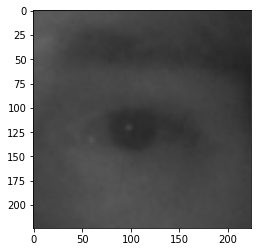

In [282]:
plt.imshow(new_array)

In [283]:
X_input = X_input / 255.

In [284]:
prediction = model.predict(X_input)

In [285]:
prediction

array([[0.9999032]], dtype=float32)

In [286]:
%cd /kaggle/working

/kaggle/working


In [287]:
model.save('Drowsiness.h5')

In [288]:
!ls

Drowsiness.h5  __notebook_source__.ipynb
